# Copyright Tasks Injectrange Plots

In this notebook i will be plotting the memorization trends of the 1b 100b toks injectrange models along with the corresponding standard and perturbed model. 

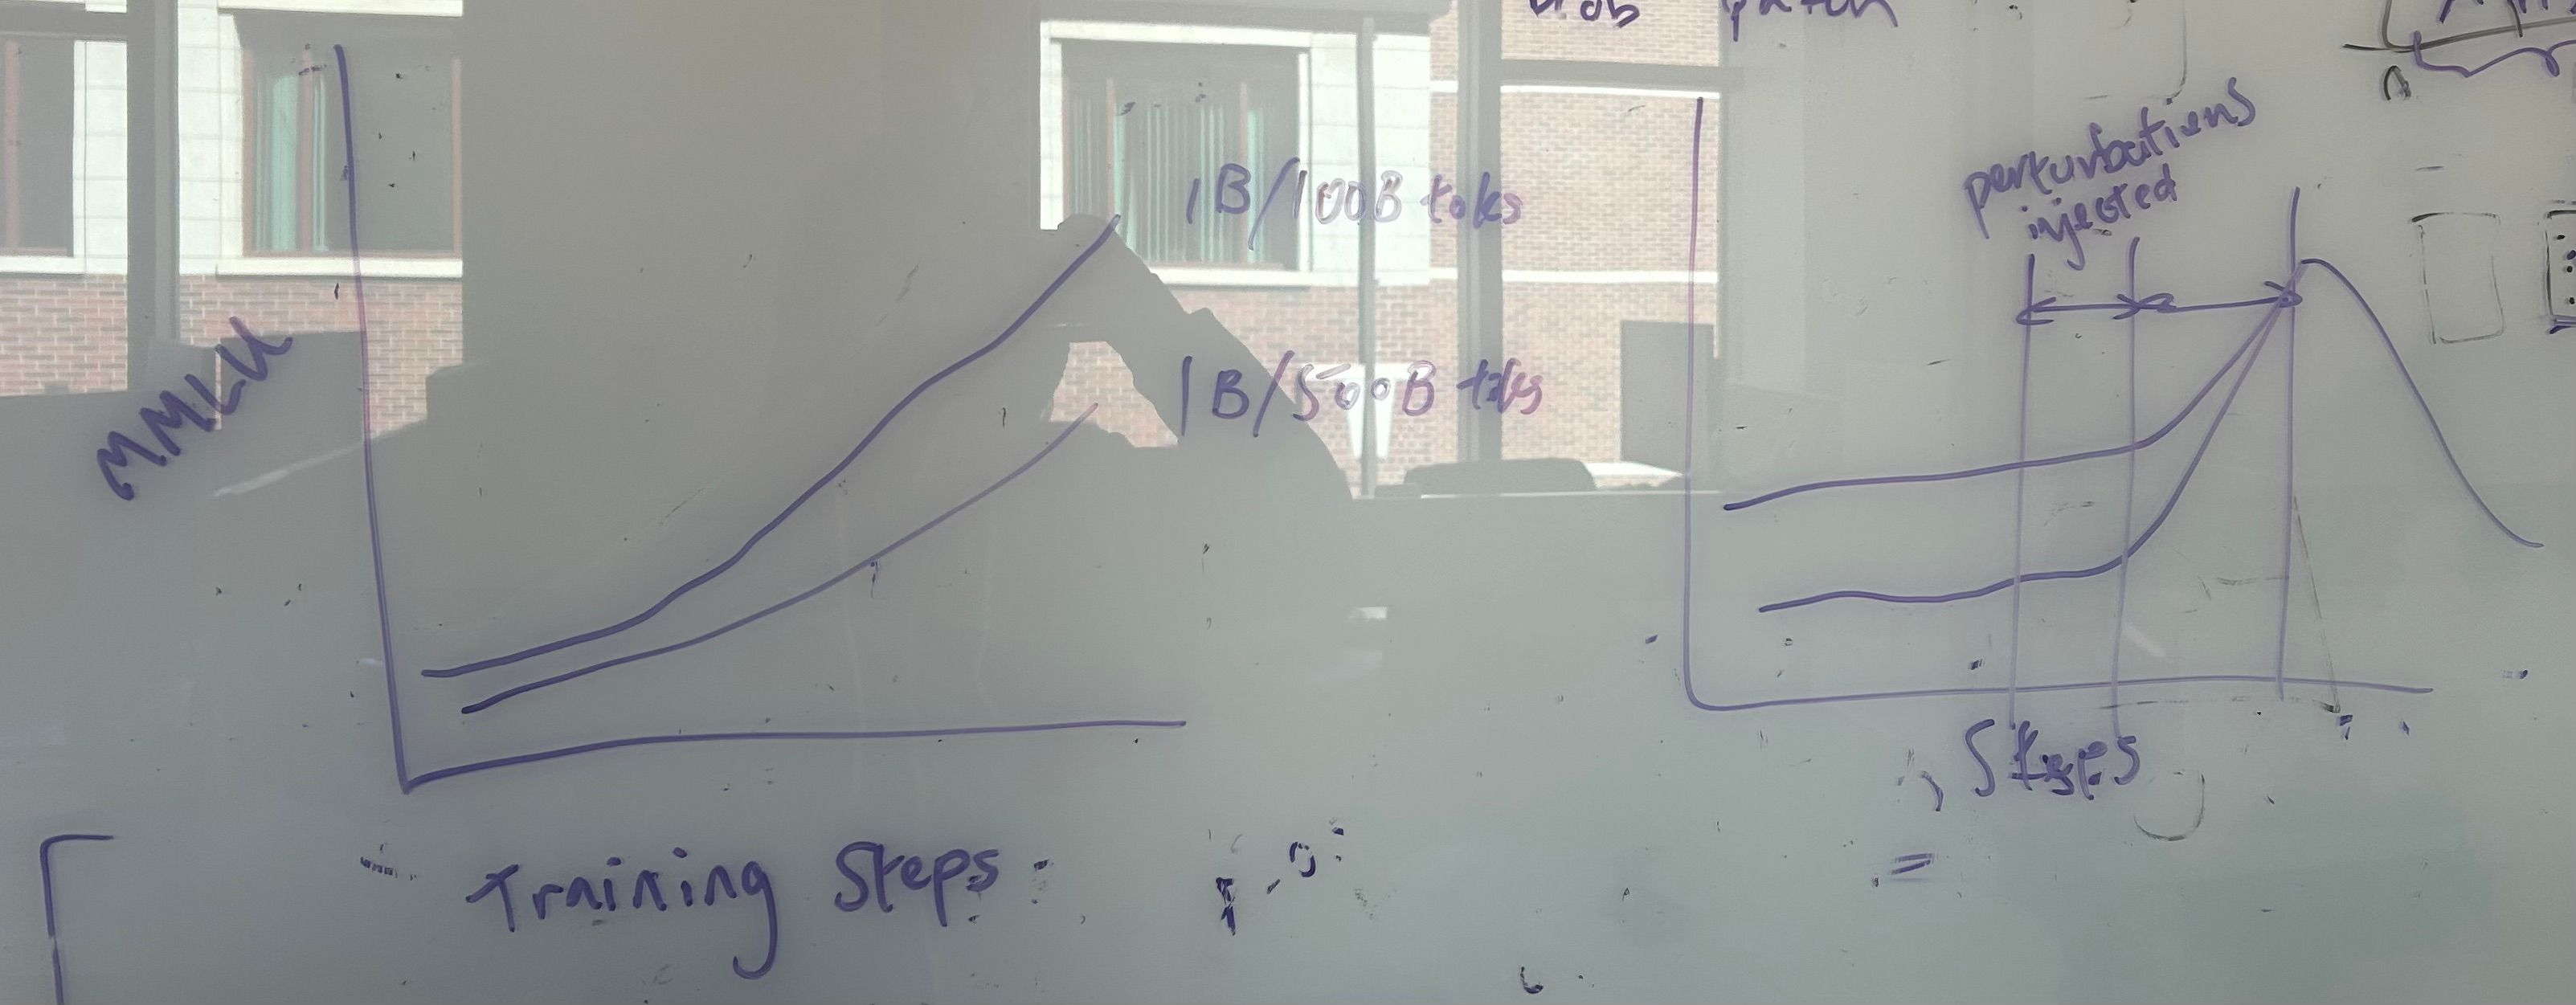
I will be attempting to get a plot similar to the one drawn above. On the y-axis will be average accuracy/perplexity, on the x-axis will be timesteps.

In [1]:
%pdb on

Automatic pdb calling has been turned ON


In [2]:
import json
import pandas as pd
import numpy as np
import glob
import os
from math import exp
import re
from git import Repo
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from huggingface_hub import list_repo_refs

In [3]:
def compute_avg_acc(filepath):
    sum_acc = 0.0
    sum_num_examples = 0.0
    for fp in glob.glob(filepath):
        with open(fp, "rt") as f:
            for line in f:
                obj = json.loads(line)
                meta = json.loads(obj['doc']['meta'])
                if meta['duplicates'] == 256:
                    sum_acc += obj['acc']
                    sum_num_examples += 1
        
    avg = sum_acc / sum_num_examples
    return avg

In [45]:
def get_all_accs(filepath):
    all_accs = []
    for fp in glob.glob(filepath):
        with open(fp, "rt") as f:
            for line in f:
                obj = json.loads(line)
                meta = json.loads(obj['doc']['meta'])
                if meta['duplicates'] == 256:
                    all_accs.append(obj['acc'])
        
    return all_accs

In [4]:
def compute_avg_ppl(filepath):
    all_nlls = []
    for fp in glob.glob(filepath):
        with open(fp, "rt") as f:
            for line in f:
                obj = json.loads(line)
                meta = json.loads(obj['doc']['meta'])
                if meta['duplicates'] == 256:
                    nll = obj['byte_perplexity'][0]
                    normalizer = obj['byte_perplexity'][1]
                    all_nlls.append(nll/normalizer)
        
    avg = np.mean(all_nlls)
    return avg

In [46]:
def get_all_ppls(filepath):
    all_ppls = []
    for fp in glob.glob(filepath):
        with open(fp, "rt") as f:
            for line in f:
                obj = json.loads(line)
                meta = json.loads(obj['doc']['meta'])
                if meta['duplicates'] == 256:
                    nll = obj['byte_perplexity'][0]
                    normalizer = obj['byte_perplexity'][1]
                    all_ppls.append(nll/normalizer)
        
    return all_ppls

In [5]:
def parse_checkpoints(model):
    """
    Extract checkpoint numbers (as ints) from a list of GitRefInfo objects returned by Huggingface API.
    Only keeps refs whose name starts with 'step'.
    """
    refs = list_repo_refs(f"allegrolab/{model}").tags
    checkpoints = []
    for ref in refs:
        if ref.name.startswith("step"):
            try:
                step_num = int(ref.name.replace("step", ""))
                if step_num >= 2000: # dont want earlier checkpoints plotted
                    checkpoints.append(step_num)
            except ValueError:
                # in case a tag isn't just step<number>, skip it
                continue
    return sorted(checkpoints)

In [41]:
tasks = [
    "wikipedia_hubble",
    # "wikipedia_hubble_verbatim_p50",
    "gutenberg_unpopular_hubble",
    # "gutenberg_unpopular_hubble_verbatim_p50",
    "gutenberg_popular_hubble",
    # "gutenberg_popular_hubble_verbatim_p50",
    "paws_hubble",
    "mrpc_hubble",
]

In [42]:
metrics = [
    'byte_perplexity',
    # 'rougeL_f1_stemmed',
    'byte_perplexity',
    # 'rougeL_f1_stemmed',
    'byte_perplexity',
    # 'rougeL_f1_stemmed',
    'acc',
    'acc',
]

In [43]:
models = [
    'hubble-1b-100b_toks-standard-hf',
    'hubble-1b-100b_toks-perturbed-hf',
    'hubble-1b-100b_toks-injectrange_0_25-hf',
    'hubble-1b-100b_toks-injectrange_25_50-hf',
    'hubble-1b-100b_toks-injectrange_50_75-hf',
    # 'hubble-1b-100b_toks-injectrange_75_100-hf',
    'hubble-1b-100b_toks-injectrange_0_50-hf',
    # 'hubble-1b-100b_toks-injectrange_50_100-hf',
]

## Creating the DFs
now that i've rerun missing checkpoings and verified i have all of them, let's create the dict of dataframes to reuse ameya's plotting code

In [47]:
dfs = {}

for task, metric in zip(tasks, metrics):
    all_model_names = []
    all_checkpoints = []
    all_metrics = []
    
    for model in models:
        metrics_one_file = []
        checkpoints = parse_checkpoints(model)
        
        for checkpoint in checkpoints:
            filepath = f'/project2/robinjia_875/nityakas/outputs/copyright-injectrange+baselines/sample_{model}_step{checkpoint}/allegrolab__{model}/samples_{task}_*.jsonl'
            
            metrics_one_file = get_all_accs(filepath) if metric == "acc" else get_all_ppls(filepath)
            all_metrics.extend(metrics_one_file) # using extend() bc u want to extend the list, not add the list as a new entry and create a list of lists sitch (which is what append would do)
        
            
            all_checkpoints.extend([checkpoint]*len(metrics_one_file))

            model_name = model.removeprefix("hubble-1b-100b_toks-").removesuffix("-hf")
            all_model_names.extend([model_name]*len(metrics_one_file))

        
    df = pd.DataFrame({
        "Model" : all_model_names, 
        "Checkpoints" : all_checkpoints,
        metric: all_metrics 
    })

    dfs[task] = df

In [48]:
dfs["wikipedia_hubble"]

Model  Checkpoints  byte_perplexity
0             standard         2000        -0.816901
1             standard         2000        -1.018905
2             standard         2000        -1.183714
3             standard         2000        -0.913605
4             standard         2000        -0.924623
...                ...          ...              ...
9875  injectrange_0_50        48000        -0.522433
9876  injectrange_0_50        48000        -0.525577
9877  injectrange_0_50        48000        -0.569138
9878  injectrange_0_50        48000        -0.446231
9879  injectrange_0_50        48000        -0.582996

[9880 rows x 3 columns]

## Plotting everything

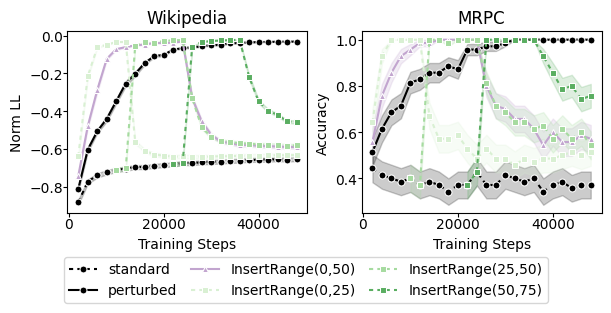

In [53]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.transforms import Bbox

copyright_results = dfs

cols_per_row = [2]

max_cols = max(cols_per_row)
nrows = len(cols_per_row)

fig = plt.figure(figsize=(6, 2.5), layout="constrained")
gs = gridspec.GridSpec(nrows, max_cols, figure=fig)

axes = []
for r, ncols in enumerate(cols_per_row):
    row_axes = []
    # Compute spacing: distribute max_cols evenly across ncols plots
    span = max_cols // ncols  
    offset = (max_cols - span * ncols) // 2  # center them
    for c in range(ncols):
        start = offset + c * span
        end = start + span
        ax = fig.add_subplot(gs[r, start:end])  # span across cells
        row_axes.append(ax)
    axes.append(row_axes)

metric_labels = {
    "byte_perplexity": "Norm LL",
    "acc": "Accuracy",
    "exact_match": "Accuracy",
    # add more if needed
    "squad_recall": "Word Recall",
}

# IMPORTANT: I REMOVED THE CORPUS ENTRIES
tasks = [
    (copyright_results, "wikipedia_hubble", "Wikipedia", 0, 0, "byte_perplexity"),
    # (copyright_results, "gutenberg_popular_hubble", "Gutenberg (Popular)", 0, 1, "byte_perplexity"),
    (copyright_results, "mrpc_hubble", "MRPC", 0, 1, "acc"),
]

line_styles = {
    'standard': (2, 2),
    'perturbed': (),
    'InsertRange(0,25)': (2, 2),
    'InsertRange(25,50)': (2, 2),
    'InsertRange(50,75)': (2, 2),
    'InsertRange(75,100)': (2, 2),
    'InsertRange(0,50)': (),
    'InsertRange(50,100)': (),
}
hue_colors = {
    'standard': "#000000",
    'perturbed': "#000000",
    'InsertRange(0,25)': "#d9f0d3",
    'InsertRange(25,50)': "#a6dba0",
    'InsertRange(50,75)': "#5aae61",
    'InsertRange(75,100)': "#1b7837",
    'InsertRange(0,50)': "#c2a5cf",
    'InsertRange(50,100)': "#762a83",
}
hue_markers = {
    'standard': "o",
    'perturbed': "o",
    'InsertRange(0,25)': 's',
    'InsertRange(25,50)': 's',
    'InsertRange(50,75)': 's',
    'InsertRange(75,100)': 's',
    'InsertRange(0,50)': '^',
    'InsertRange(50,100)': '^',
}

def _get_run_tag(m_nm):
    if 'standard' in m_nm:
        return 'standard'
    if 'perturbed' in m_nm:
        return 'perturbed'
    if 'injectrange_0_25' in m_nm:
        return 'InsertRange(0,25)'
    if 'injectrange_25_50' in m_nm:
        return 'InsertRange(25,50)'
    if 'injectrange_50_75' in m_nm:
        return 'InsertRange(50,75)'
    if 'injectrange_75_100' in m_nm:
        return None  # explicitly ignore this model bc i dont want it plotted
        return 'InsertRange(75,100)'
    if 'injectrange_0_50' in m_nm:
        return 'InsertRange(0,50)'
    if 'injectrange_50_100' in m_nm:
        return None  # explicitly ignore this model bc i dont want it plotted
        return 'InsertRange(50,100)'  
    raise ValueError(f'Unsupported model name: {m_nm}')

# --- plotting loop (same as before) ---
for results, task, title, r, c, metric in tasks:
    df = results[task]
    ax = axes[r][c]

    temp_df = df.copy()
    temp_df['Corpus Type'] = temp_df['Model'].apply(lambda n_: _get_run_tag(n_))
    temp_df = temp_df.dropna(subset=['Corpus Type']) # u need this if ur returning None for any models in _get_run_tag()

    sns.lineplot(
        data=temp_df,
        x="Checkpoints",
        y=metric,
        hue="Corpus Type",
        style="Corpus Type",
        ax=ax,
        markers=hue_markers,
        markersize=5,
        linewidth=1.5,
        hue_order=['standard',
                   'perturbed',
                   'InsertRange(0,50)',
                   # 'InsertRange(50,100)',
                   'InsertRange(0,25)',
                   'InsertRange(25,50)',
                   'InsertRange(50,75)',
                   # 'InsertRange(75,100)',
                  ],
        dashes=line_styles,
        palette=hue_colors,
        errorbar="se", 
        # err_style='bars',
    )
    ax.set_ylabel(metric_labels.get(metric, metric))
    ax.set_title(title)
    # ax.set_xscale('symlog', base=4)
    # ax.set_xlim(.5, 2048)

    if r==0 and c==0:
        handles, labels = ax.get_legend_handles_labels()

        # place a single legend at the bottom of the figure
        fig.legend(
            handles, labels,
            loc="lower center",
            ncol=3,            # adjust depending on how many entries you have
            # frameon=False
            bbox_to_anchor=(0.5, -0.22),  # position legend *below* the figure
            bbox_transform=fig.transFigure,
            columnspacing=1.0,
        )
    
    leg = ax.get_legend()
    if leg:
        leg.remove()

    ax.tick_params(axis='both', pad=0, length=3)
    ax.set_xlabel("Training Steps")
    ax.tick_params(axis='y', pad=0)

# Force layout to finalize so ax.get_position() returns the real positions.
fig.canvas.draw()
renderer = fig.canvas.get_renderer()


# plt.show()
plt.savefig("figures/injectrange-full.pdf", format="pdf", bbox_inches="tight")

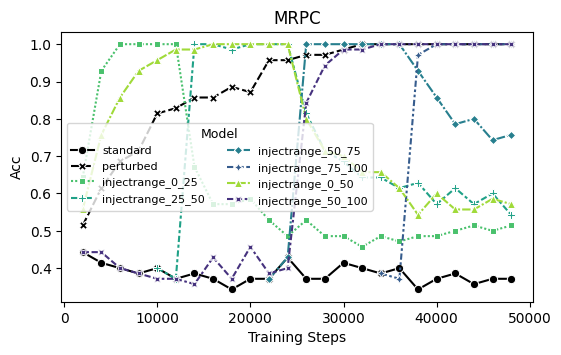

In [25]:
models_row1 = [
    'hubble-1b-100b_toks-standard-hf',
    'hubble-1b-100b_toks-perturbed-hf',
    # 'hubble-1b-100b_toks-injectrange_0_25-hf',
    'hubble-1b-100b_toks-injectrange_25_50-hf',
    # 'hubble-1b-100b_toks-injectrange_50_75-hf',
    # 'hubble-1b-100b_toks-injectrange_75_100-hf',
    'hubble-1b-100b_toks-injectrange_0_50-hf',
    # 'hubble-1b-100b_toks-injectrange_50_100-hf',
]
models_row2 = [
    'hubble-1b-100b_toks-standard-hf',
    'hubble-1b-100b_toks-perturbed-hf',
    # 'hubble-1b-100b_toks-injectrange_0_25-hf',
    # 'hubble-1b-100b_toks-injectrange_25_50-hf',
    # 'hubble-1b-100b_toks-injectrange_50_75-hf',
    'hubble-1b-100b_toks-injectrange_75_100-hf',
    # 'hubble-1b-100b_toks-injectrange_0_50-hf',
    'hubble-1b-100b_toks-injectrange_50_100-hf',
]

metric_labels = {
    'byte_perplexity': 'log(byte_perplexity)',
    'acc': 'Accuracy',
}
task_labels = {
    "wikipedia_hubble": "Wikipedia",
    "gutenberg_unpopular_hubble": "Gutenberg (Unpopular)",
    "gutenberg_popular_hubble": "Gutenberg (Popular)",
    "paws_hubble": "PAWS",
    "mrpc_hubble": "MRPC",
}

fig = plt.figure(figsize=(5.5, 5.5/1.6), layout='constrained')

sns.lineplot(
    data=df,
    x="Checkpoints",
    y=f"avg {metric}",
    hue="Model",
    style="Model",
    markers=True,
    errorbar='se',
    palette=['k', 'k'] + list(sns.color_palette('viridis_r', 6)[1:5]) + list([sns.color_palette('viridis_r', 6)[0], sns.color_palette('viridis_r', 6)[5]]),
)

plt.title(task_labels.get(task, task))
plt.ylabel(metric_labels.get(metric, metric))
plt.xlabel("Training Steps")
plt.legend(title="Model", ncol=2, fontsize=8, title_fontsize=9)
set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k' if x >= 1000 else int(x)))

plt.savefig(f'figures/injectrange/{task}_rev4.png', format="png", bbox_inches="tight")

2x3 plot for the ICLR paper:   
One row with standard, perturbed, 25-50, 0-50 plotted for wikipedia, gutenberg unpopular and mrpc. 
Second row with standard, perturbed, 50-100, 75-100 plotted for wikipedia, gutenberg unpopular and mrpc

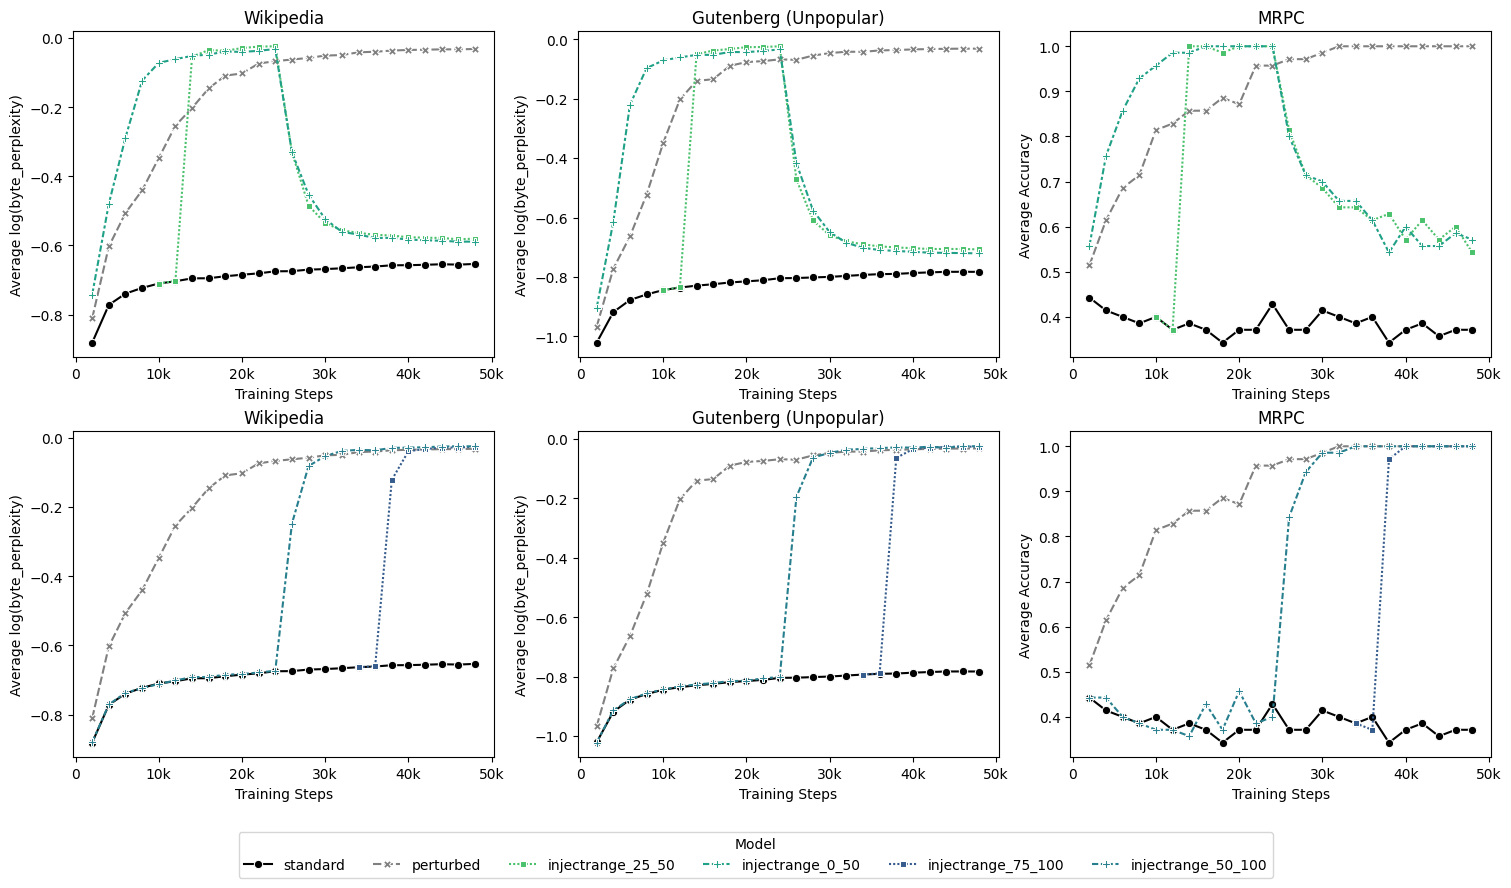

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Define which models to show in each row
row1_models = ["standard", "perturbed", "injectrange_25_50", "injectrange_0_50"]
# row2_models = ["standard", "perturbed", "injectrange_50_100", "injectrange_75_100"]

# The tasks you care about
row_tasks = ["wikipedia_hubble", "gutenberg_unpopular_hubble", "mrpc_hubble"]
row_metrics = ['byte_perplexity', 'byte_perplexity', 'acc']

line_styles = {
    'standard': (2, 2),
    'perturbed': (),
    'injectrange(0,25)': (2, 2),
    'injectrange(25,50)': (2, 2),
    'injectrange(50,75)': (2, 2),
    # 'injectrange(75,100)': (2, 2),
    'injectrange(0,50)': (),
    # 'injectrange(50,100)': (),
}
hue_colors = {
    'standard': "#000000",
    'perturbed': "#000000",
    'injectrange(0,25)': "#d9f0d3",
    'injectrange(25,50)': "#a6dba0",
    'injectrange(50,75)': "#5aae61",
    'injectrange(75,100)': "#1b7837",
    'injectrange(0,50)': "#c2a5cf",
    'injectrange(50,100)': "#762a83",
}
hue_markers = {
    'standard': "o",
    'perturbed': "o",
    'injectrange(0,25)': 's',
    'injectrange(25,50)': 's',
    'injectrange(50,75)': 's',
    'injectrange(75,100)': 's',
    'injectrange(0,50)': '^',
    'injectrange(50,100)': '^',
}

# Make one palette dict covering all 6 models
model_palette = {
    "standard": "black",
    "perturbed": "gray",
    "injectrange_25_50": sns.color_palette("viridis_r", 6)[1],
    "injectrange_0_50": sns.color_palette("viridis_r", 6)[2],
    "injectrange_50_100": sns.color_palette("viridis_r", 6)[3],
    "injectrange_75_100": sns.color_palette("viridis_r", 6)[4],
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False, layout="constrained")

# Row 1
for i, task in enumerate(row_tasks):
    metric = row_metrics[i]
    ax = axes[0, i]
    df = dfs[task]
    sns.lineplot(
        data=df[df["Model"].isin(row1_models)],
        x="Checkpoints",
        y=f"avg {metric}",
        hue="Model",
        style="Model",
        markers=True,
        errorbar="se",
        ax=ax,
        palette=model_palette
    )
    ax.set_title(task_labels.get(task, task))
    ax.set_xlabel("Training Steps")
    ax.set_ylabel(f'Average {metric_labels.get(metric, metric)}')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k' if x >= 1000 else int(x)))

# Row 2
for i, task in enumerate(row_tasks):
    metric = row_metrics[i]
    ax = axes[1, i]
    df = dfs[task]
    sns.lineplot(
        data=df[df["Model"].isin(row2_models)],
        x="Checkpoints",
        y=f"avg {metric}",
        hue="Model",
        style="Model",
        markers=True,
        errorbar="se",
        ax=ax,
        palette=model_palette
    )
    ax.set_title(task_labels.get(task, task))
    ax.set_xlabel("Training Steps")
    ax.set_ylabel(f'Average {metric_labels.get(metric, metric)}')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k' if x >= 1000 else int(x)))

# Collect legend handles/labels from all subplots
all_handles, all_labels = [], []
for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)

# Deduplicate while preserving order
unique = dict(zip(all_labels, all_handles))

# Place one combined legend at bottom
fig.legend(
    unique.values(),
    unique.keys(),
    title="Model",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),   # move down
    ncol=len(unique)
)

# Remove legends from individual subplots
for ax in axes.flat:
    ax.legend_.remove()
plt.savefig("figures/injectrange/combined_plot_rev2.png", format="png", bbox_inches="tight")
plt.show()

just for future reference, here's a diagram explaining how the code above loops thru each task and creates a dataframe for its plot:
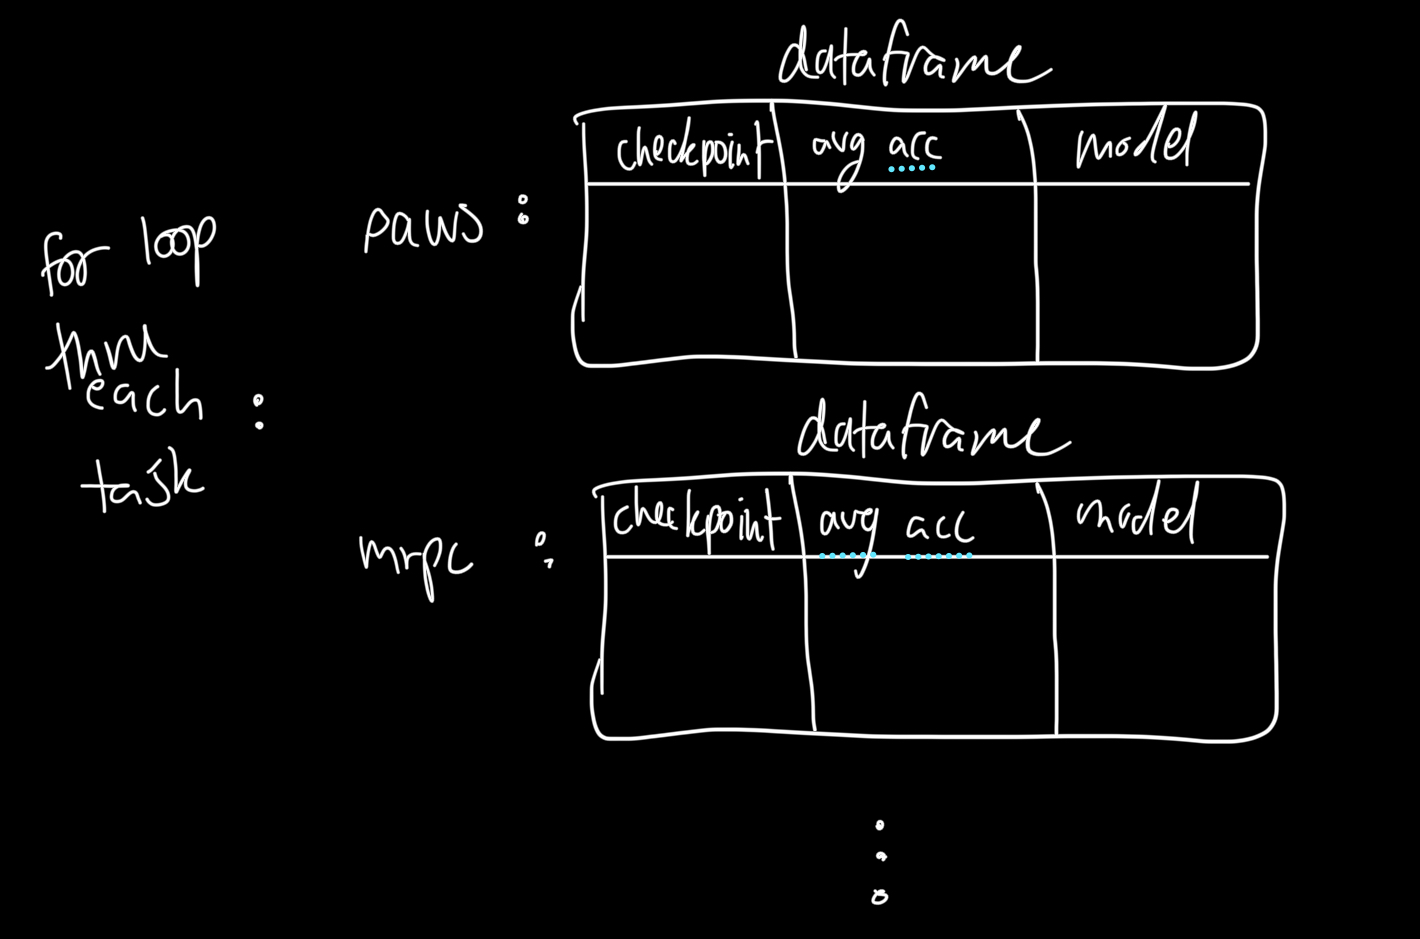

## Missing Checkpoints
*it came to my attention that some checkpoints are missing. let's see which ones:*

In [9]:
def get_hf_checkpoints(model):
    refs = list_repo_refs(f"allegrolab/{model}").tags
    return sorted(
        int(ref.name.replace("step", ""))
        for ref in refs
        if ref.name.startswith("step")
    )
    
def get_local_checkpoints(model, base="/project2/robinjia_875/nityakas/outputs/copyright-injectrange+baselines"):
    pattern = f"{base}/sample_{model}_step*"
    dirs = glob.glob(pattern)
    return sorted(
        int(os.path.basename(d).split("step")[-1])
        for d in dirs
    )

def identify_missing_checkpoints(model):
    hf = set(get_hf_checkpoints(model))
    local = set(get_local_checkpoints(model))
    missing = sorted(hf - local)
    return missing

for model in models:
    print(f'{model} is missing:\n {identify_missing_checkpoints(model)}\n****************************************\n')

hubble-1b-100b_toks-standard-hf is missing:
 []
****************************************

hubble-1b-100b_toks-perturbed-hf is missing:
 []
****************************************

hubble-1b-100b_toks-injectrange_0_25-hf is missing:
 []
****************************************

hubble-1b-100b_toks-injectrange_25_50-hf is missing:
 []
****************************************

hubble-1b-100b_toks-injectrange_50_75-hf is missing:
 []
****************************************

hubble-1b-100b_toks-injectrange_75_100-hf is missing:
 []
****************************************

hubble-1b-100b_toks-injectrange_0_50-hf is missing:
 []
****************************************

hubble-1b-100b_toks-injectrange_50_100-hf is missing:
 []
****************************************

